# Unsupervised Learning

In contrast to everything we've seen up till now, the data in these problems is **unlabeled**. This means that the metrics that we've used up till now (e.g. accuracy) won't be available to evaluate our models with. Furthermore, the loss functions we've seen also require labels. Unsupervised learning algorithms need to describe the hidden structure in the data.

# Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is an unsupervised learning problem, where the goal is to split the data into several groups called **clusters**.  

![](https://cdn-images-1.medium.com/max/1600/0*9ksfYh14C-ARETav.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

As stated previously, in unsupervised problems the data **isn't** accompanied by labels. We don't even know **how many** groups our data belongs to.

To illustrate how unsupervised algorithms cope with the challenge, we'll create an easy example consisting of 100 data points that can easily be split into two categories (of 50 points each). We'll attempt to create an algorithm that can identify the two groups and split the data accordingly.

Text(0.5,1,'Data points randomly placed into two groups')

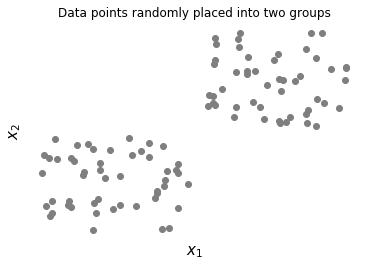

In [2]:
#                                                  CODE:
#                              --------------------------------------------

np.random.seed(55)  # for reproducibility

p1 = np.random.rand(50,2) * 10 + 1   # 100 random numbers uniformly distributed in [1,11). these are stored in a 50x2 array.
p2 = np.random.rand(50,2) * 10 + 12  # 100 random numbers uniformly distributed in [12,22). these are stored in a 50x2 array.


points = np.concatenate([p1, p2])  # we merge the two into a 100x2 array
                                   # the first column represents the feature x1, while the second represents x2
                                   # subsequently the 30th row represents the two coordinates of the 30th sample

#                                                PLOTTING:
#                              --------------------------------------------

ax = plt.subplot(111)  # create a subplot to get access to the axes object

ax.scatter(points[:,0], points[:,1], c='#7f7f7f')  # scatter the points and color them all as gray
                                                   # this is done to show that we don't know which
                                                   # categories the data can be split into

# Remove ticks from both axes
ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)  

# Remove the spines from the figure
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set labels and title
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)
ax.set_title('Data points randomly placed into two groups')

## K-Means

**[k-means](https://en.wikipedia.org/wiki/K-means_clustering)**, is probably the simplest clustering algorithm. Let's see how it works step by step.

The most important hyperparameter is $k$, a number signifying the number of clusters the algorithm would attempt to group the data into. K-means represents clusters through points in space called **centroids**. Initially the centroids are **placed randomly**. Afterwards the distance of each centroid to every data point is computed. These points are **assigned** to the cluster with the closest centroid. Finally, for each cluster, the mean location of all its data points is calculated. Each cluster's centroid is moved to that location (this movement is also referred to as an **update**). The assignment and update stages are repeated until convergence.

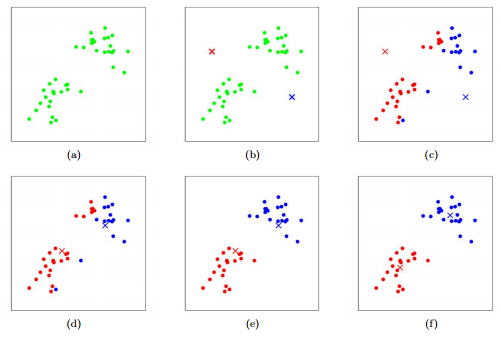

In the above image:

- (a): Data points
- (b): Random initialization
- (c): Initial assignment
- (d): Initial centroid update
- (e): Second assignment
- (f): Second update 

The whole training procedure can also be viewed in the image below:

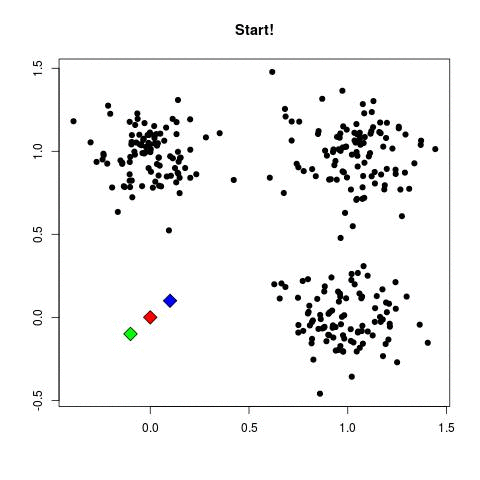

In order to better understand the algorithm, we'll attempt to create a simple k-means algorithm on our own. As previously stated, the only hyperparameter we need to define is $k$. The first step is to create $k$ centroids, randomly placed near the data points.

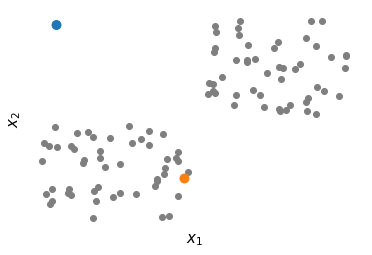

In [3]:
#                                                  CODE:
#                              --------------------------------------------

np.random.seed(55)  # for reproducibility

# Select the value of the hyperparameter k:
k = 2  

# STEP 1:
# Randomly place two centroids in the same space as the data points
centroids = np.random.rand(k, 2) * 22  

#                                                PLOTTING:
#                              --------------------------------------------


colors = ['#1f77b4', '#ff7f0e']  # select colors for the two groups

ax = plt.subplot(111)

ax.scatter(points[:, 0], points[:, 1], c='#7f7f7f')               # data points in gray
ax.scatter(centroids[:, 0], centroids[:, 1], color=colors, s=80)  # centroids in orange and blue

# Aesthetic parameters:
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

In order to continue, we need a way to measure *how close* one point is to another, or in other words a *distance metric*. For this purpose, we will use probably the most common distance metric, [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

The distance of two points $a$ and $b$ is calculated as follows:

$$
d \left( a, b \right) = \sqrt{ \left( a_x - b_x \right)^2 + \left( a_y - b_y \right)^2}
$$

Of course there are many more [distance metrics][1] we can use.

[1]: https://en.wikipedia.org/wiki/Metric_(mathematics)

In [4]:
#                                                  CODE:
#                              --------------------------------------------

def euclidean_distance(point1, point2):
    """
    calculates the Euclidean distance between point1 and point2. these points need to be two-dimensional.
    """
    return np.sqrt( (point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2 )

print('the distance from (5,2) to (2,5) is:    ', euclidean_distance((5, 2), (2, 5)))
print('the distance from (3,3) to (3,3) is:    ', euclidean_distance((3, 3), (3, 3)))
print('the distance from (1,12) to (12,15) is: ', euclidean_distance((1, 12), (12, 15)))

the distance from (5,2) to (2,5) is:     4.242640687119285
the distance from (3,3) to (3,3) is:     0.0
the distance from (1,12) to (12,15) is:  11.40175425099138


Tip: Alternatively we could use the built-in function [pdist](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.spatial.distance.pdist.html) from scipy.spatial.distance.

The second step would be to calculate the distance from each point to every centroid. To do this, we'll use the previously defined function.

In [5]:
#                                                  CODE:
#                              --------------------------------------------

def calc_distances(centroids, points):
    """
    Calculates the Euclidean distance from each centroid to every point.
    """
    distances = np.zeros((len(centroids), len(points)))  # array with (k x N) dimensions, where we will store the distances
    for i in range(len(centroids)):
        for j in range(len(points)):
            distances[i,j] = euclidean_distance(centroids[i], points[j])
    return distances
    # The above could also be written as:
    # return np.reshape(np.array([euclidean_distance(centroids[i], points[j]) for i in range(len(centroids)) 
    #                             for j in range(len(points))]), (len(centroids), len(points)))
    

print('first 10 distances from the first centroid:')
print(calc_distances(centroids, points)[0, :10])
print('...')

first 10 distances from the first centroid:
[10.66051639 18.34697375 18.03210907 21.35516886 12.70487826 12.63056227
 14.22553545 13.44270615 17.74860179 11.96433364]
...


Afterwards, we'll use these distances to assign the data points into clusters (depending on which centroid they are closer to).

In [6]:
#                                                  CODE:
#                              --------------------------------------------

def assign_cluster(centroids, points):
    """
    Calculates the Euclidean distance from each centroid to every point. Assigns the points to clusters.
    """
    distances = calc_distances(centroids, points)
    return np.argmin(distances, axis=0)

print('Which cluster does each point belong to?')
print(assign_cluster(centroids, points))

Which cluster does each point belong to?
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1]


Due to the distance metric we elected, the two groups are geometrically separated through their perpendicular bisector. The lines or planes that separate groups are called [decision boundaries](https://en.wikipedia.org/wiki/Decision_boundary). 

We'll proceed to draw this line.

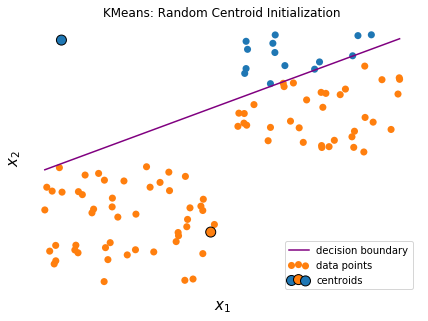

In [7]:
#                                                PLOTTING:
#                              --------------------------------------------

# First, we'll calculate the perpendicular bisector's function
def generate_perp_bisector(centroids):
    midpoint = ((centroids[0, 0] + centroids[1, 0]) / 2, (centroids[0, 1] + centroids[1, 1]) / 2)  # the midpoint of the two centroids
    slope = (centroids[1, 1] - centroids[0, 1]) / (centroids[1, 0] - centroids[0, 0])              # the angle of the line that connects the two centroids
    perpendicular = -1/slope                                                                       # its perpendicular
    return lambda x:  perpendicular * (x - midpoint[0]) + midpoint[1]                              # the function

perp_bisector = generate_perp_bisector(centroids)

# Color mapping
map_colors = {0:'#1f77b4', 1:'#ff7f0e'}
point_colors = [map_colors[i] for i in assign_cluster(centroids, points)]

# Range of values in the x axis
x_range = [points[:, 0].min(), points[:, 0].max()]

fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Scatter the points
ax.scatter(points[:, 0], points[:, 1], c=point_colors, s=50, lw=0, edgecolor='black', label='data points')
ax.scatter(centroids[:, 0], centroids[:, 1], c=colors, s=100, lw=1, edgecolor='black', label='centroids')

# Draw the decision boundary
ax.plot(x_range, [perp_bisector(x) for x in x_range], c='purple', label='decision boundary')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: Random Centroid Initialization')

ax.legend(loc='lower right', scatterpoints=3)

The third step involves computing the mean of all points of each class and update the corresponding centroid to that location.

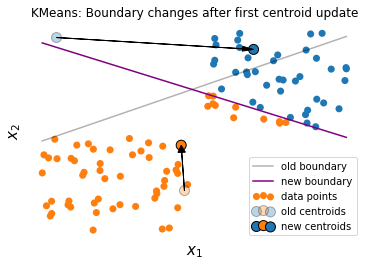

In [8]:
#                                                  CODE:
#                              --------------------------------------------

def update_centers(centroids, points):
    clusters = assign_cluster(centroids, points)  # assign points to clusters
    new_centroids = np.zeros(centroids.shape)  # array where the new positions will be stored
    for i in range(len(centroids)):
        cluster_points_idx = [j for j in range(len(clusters)) if clusters[j] == i]  # finds the positions of the points that belong to cluster i
        if cluster_points_idx:  # if the centroid has any data points assigned to it, update its position
            cluster_points = points[cluster_points_idx]  # slice the relevant positions
            new_centroids[i, 1] = cluster_points[:,1].sum() / len(cluster_points)  # calculate the centroid's new position
            new_centroids[i, 0] = cluster_points[:,0].sum() / len(cluster_points)
        else:  # if the centroid doesn't have any points we keep its old position
            new_centroids[i, :] = centroids[i, :]
    return new_centroids


#                                                PLOTTING:
#                              --------------------------------------------

# Compute the new centroid positions and generate the decision boundary and the new assignments
new_centroids = update_centers(centroids, points)
new_boundary = generate_perp_bisector(new_centroids)
new_colors = [map_colors[i] for i in assign_cluster(new_centroids, points)]

# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Scatter the points
ax.scatter(points[:, 0], points[:, 1], c=new_colors, s=50, lw=0, edgecolor='black', label='data points')
ax.scatter(centroids[:, 0], centroids[:, 1], c=colors, s=100, lw=1, edgecolor='black', alpha=0.3, label='old centroids')
ax.scatter(new_centroids[:, 0], new_centroids[:, 1], c=colors, s=100, lw=1, edgecolor='black', label='new centroids')

# Draw the decision boundaries
ax.plot(x_range, [perp_bisector(x) for x in x_range], c='black', alpha=0.3, label='old boundary')
ax.plot(x_range, [new_boundary(x) for x in x_range], c='purple', label='new boundary')

# Draw the arrows
for i in range(k):
    ax.arrow(centroids[i, 0], centroids[i, 1], new_centroids[i, 0] - centroids[i, 0], new_centroids[i, 1] - centroids[i, 1],
             length_includes_head=True, head_width=0.5, color='black')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: Boundary changes after first centroid update')

ax.legend(loc='lower right', scatterpoints=3)

The second and third steps are repeated until convergence. An interactive tutorial to try out k-means for different data types and initial conditions is available [here](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/).

At this point, we'll attempt to create our own k-means class. For ease we'll try to model it to match the functionality of scikit-learn estimators, as closely as possible. The only hyperparameter, the class will accept, is the number of classes $k$. There will be two methods: `.fit()` which will initialize the centroids and handle the whole training procedure until convergence; and `.predict()` which will compute the distance between one or more points and the centroids and assign them accordingly.

In [9]:
class KMeans:
    
    def __init__(self, k, term_distance=0.05, max_steps=50, seed=None):
        self.k = k
        self.seed = seed
        self.history = [] 
        # Termination conditions:
        self.term_distance = term_distance  # minimum allowed centroid update distance before termination
        self.max_steps = max_steps          # maximum number of epochs 
        
    def initialize(self, data):
        # Place k centroids in random spots in the space defined by the date
        np.random.seed(self.seed)
        self.centroids = np.random.rand(self.k,2) * data.max()
        self.history = [self.centroids]  # holds a history of the centroids' previous locations
    
    def calc_distances(self, points):
        # Calculates the distances between the points and centroids
        distances = np.zeros((len(self.centroids), len(points)))
        for i in range(len(self.centroids)):
            for j in range(len(points)):
                distances[i,j] = self.euclidean_distance(self.centroids[i], points[j])
        return distances
 
    def assign_cluster(self, points):
        # Compares the distances between the points ant the centroids and carries out the assignment
        distances = self.calc_distances(points)
        return np.argmin(distances, axis=0)

    def update_centers(self, points):
        # Calculates the new positions of the centroids
        clusters = self.assign_cluster(points)
        new_centroids = np.zeros(self.centroids.shape)
        for i in range(len(self.centroids)):
            cluster_points_idx = [j for j in range(len(clusters)) if clusters[j] == i]
            if cluster_points_idx:
                cluster_points = points[cluster_points_idx]
                new_centroids[i, 1] = cluster_points[:,1].sum() / len(cluster_points)
                new_centroids[i, 0] = cluster_points[:,0].sum() / len(cluster_points)
            else:
                new_centroids[i, :] = self.centroids[i, :]
        return new_centroids
    
    def fit(self, data):
        # Undertakes the whole training procedure
        # 1) initializes the centroids
        # 2, 3) computes the distances and updates the centroids
        # Repeats steps (2) and (3) until a termination condition is met
        self.initialize(data)
        self.previous_positions = [self.centroids]
        step = 0
        cluster_movement = [self.term_distance + 1] * self.k
        while any([x > self.term_distance for x in cluster_movement]) and step < self.max_steps:  # checks for both termination conditions
            new_centroids = self.update_centers(data)
            self.history.append(new_centroids)  # store centroids past locations
            cluster_movement = [self.euclidean_distance(new_centroids[i,:], self.centroids[i,:]) for i in range(self.k)]
            self.centroids = new_centroids
            self.previous_positions.append(self.centroids)
            step += 1
            
    def predict(self, points):
        # Checks if points is an array with multiple points or a tuple with the coordinates of a single point
        # and carries out the assignment. This could be done through the built in 'assign_cluster' method,
        # but for reasons of clarity we elected to perform it manually.
        if isinstance(points, np.ndarray):
            if len(points.shape) == 2:
                return [np.argmin([self.euclidean_distance(point, centroid) for centroid in self.centroids]) for point in points]
        return np.argmin([self.euclidean_distance(points, self.centroids[i]) for i in range(self.k)])
        
    
    def fit_predict(self, points):
        # Runs the training phase and returns the assignment of the training data
        self.fit(points)
        return self.predict(points)
            
    @staticmethod
    def euclidean_distance(point1, point2):
        # Computes the Euclidean distance between two points
        return np.sqrt( (point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2 )

Initially, we'll run a few iterations manually (without the use of `.fit()`) to check if it works correctly.

First, let's initialize the $k$ centroids.

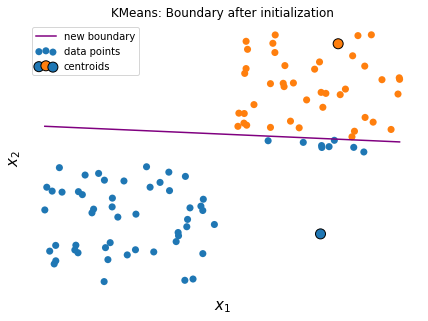

In [10]:
#                                                  CODE:
#                              --------------------------------------------

km = KMeans(2, seed=13)
km.initialize(points)

#                                                PLOTTING:
#                              --------------------------------------------

# Assign data points and generate decision boundary
point_colors = [map_colors[i] for i in km.predict(points)]
decision_boundary = generate_perp_bisector(km.centroids)

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Scatter the points and draw the decision boundary
ax.scatter(points[:, 0], points[:, 1], c=point_colors, s=50, lw=0, edgecolor='black', label='data points')
ax.scatter(km.centroids[:, 0], km.centroids[:, 1], c=colors, s=100, lw=1, edgecolor='black', label='centroids')
ax.plot(x_range, [decision_boundary(x) for x in x_range], c='purple', label='new boundary')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: Boundary after initialization')

ax.legend(loc='upper left', scatterpoints=3)

Now, we'll run an iteration and update the centroids.

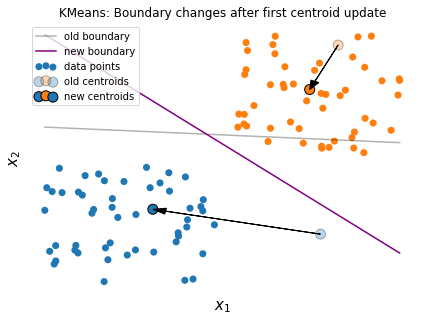

In [11]:
#                                                  CODE:
#                              --------------------------------------------

old = km.centroids
km.centroids = new = km.update_centers(points)

#                                                PLOTTING:
#                              --------------------------------------------

# Assign points and generate decision boundary
point_colors = [map_colors[i] for i in km.predict(points)]
new_boundary = generate_perp_bisector(new)

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Scatter the points and draw the decision boundary
ax.scatter(points[:, 0], points[:, 1], c=point_colors, s=50, lw=0, edgecolor='black', label='data points')
ax.scatter(old[:, 0], old[:, 1], c=colors, s=100, lw=1, edgecolor='black', alpha=0.3, label='old centroids')
ax.scatter(new[:, 0], new[:, 1], c=colors, s=100, lw=1, edgecolor='black', label='new centroids')
ax.plot(x_range, [decision_boundary(x) for x in x_range], c='black', alpha=0.3, label='old boundary')
ax.plot(x_range, [new_boundary(x) for x in x_range], c='purple', label='new boundary')

# Draw arrows
for i in range(km.k):
    plt.arrow(old[i, 0], old[i, 1], new[i, 0] - old[i, 0], new[i, 1] - old[i, 1], 
              length_includes_head=True, head_width=0.5, color='black')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: Boundary changes after first centroid update')

ax.legend(loc='upper left', scatterpoints=3)

One more iteration...

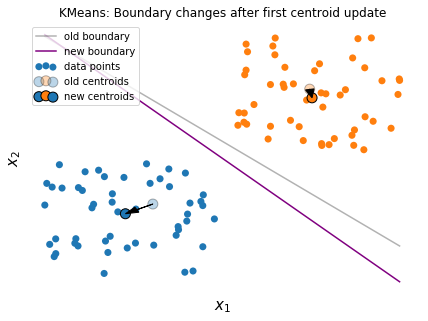

In [12]:
#                                                  CODE:
#                              --------------------------------------------

old = km.centroids
new = km.update_centers(points)

#                                                PLOTTING:
#                              --------------------------------------------

# Assign points and generate decision boundary
decision_boundary = new_boundary
point_colors = [map_colors[i] for i in km.predict(points)]
new_boundary = generate_perp_bisector(new)

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Scatter the points and draw the decision boundary
ax.scatter(points[:, 0], points[:, 1], c=point_colors, s=50, lw=0, edgecolor='black', label='data points')
ax.scatter(old[:, 0], old[:, 1], c=colors, s=100, lw=1, edgecolor='black', alpha=0.3, label='old centroids')
ax.scatter(new[:, 0], new[:, 1], c=colors, s=100, lw=1, edgecolor='black', label='new centroids')
ax.plot(x_range, [decision_boundary(x) for x in x_range], c='black', alpha=0.3, label='old boundary')
ax.plot(x_range, [new_boundary(x) for x in x_range], c='purple', label='new boundary')

# Draw arrows
for i in range(km.k):
    plt.arrow(old[i, 0], old[i, 1], new[i, 0] - old[i, 0], new[i, 1] - old[i, 1], 
              length_includes_head=True, head_width=0.5, color='black')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: Boundary changes after first centroid update')

ax.legend(loc='upper left', scatterpoints=3)

Now that we confirmed that the class' main functionality works we can try out the `.fit()` method, which handles the training procedure for as many iterations as necessary.

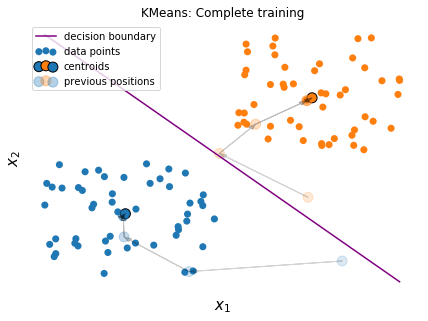

In [13]:
#                                                  CODE:
#                              --------------------------------------------

km = KMeans(2, seed=44)
km.fit(points)

#                                                PLOTTING:
#                              --------------------------------------------

# Assign points and generate decision boundary
point_colors = [map_colors[i] for i in km.predict(points)]
decision_boundary = generate_perp_bisector(km.centroids)

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Scatter the points and draw the decision boundary
ax.scatter(points[:, 0], points[:, 1], c=point_colors, s=50, lw=0, edgecolor='black', label='data points')
ax.scatter(km.centroids[:, 0], km.centroids[:, 1], c=colors, s=100, lw=1, edgecolor='black', label='centroids')
ax.plot(x_range, [new_boundary(x) for x in x_range], c='purple', label='decision boundary')

# We'll use km.history to plot the centroids' previous locations
steps = len(km.history)
for s in range(steps-2): # the last position (where s==steps-1) is already drawn; 
                         # we'll ignore the penultimate position for two reasons:
                         # 1) it represents the last iteration, where the centroid movement was minimal and 
                         # 2) because the arrows must be 1 less than the points
    ax.scatter(km.history[s][:, 0], km.history[s][:, 1], c=colors, s=100, alpha=1.0 / (steps-s))

    for i in range(km.k):
        ax.arrow(km.history[s][i, 0], km.history[s][i, 1], km.history[s + 1][i, 0] - km.history[s][i, 0],
                 km.history[s + 1][i, 1] - km.history[s][i, 1], length_includes_head=True, head_width=0.3,
                 color='black', alpha=1.0 / (steps - s))

# Draw one more time to register the label
ax.scatter(km.history[s][:, 0], km.history[s][:, 1], c=colors, s=100, alpha=1.0 / (steps-s), label='previous positions')
        
# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: Complete training')

ax.legend(loc='upper left', scatterpoints=3)

Once the system is trained, we can use `.predict()` to figure out which cluster a point belongs to.

In [14]:
print(' (0,0)  belongs to cluster:', km.predict((0, 0)))
print(' (5,5)  belongs to cluster:', km.predict((5, 5)))
print('(10,10) belongs to cluster:', km.predict((10, 10)))
print('(15,15) belongs to cluster:', km.predict((15, 15)))
print('(20,20) belongs to cluster:', km.predict((20, 20)))
print('(25,25) belongs to cluster:', km.predict((25, 25)))

 (0,0)  belongs to cluster: 0
 (5,5)  belongs to cluster: 0
(10,10) belongs to cluster: 0
(15,15) belongs to cluster: 1
(20,20) belongs to cluster: 1
(25,25) belongs to cluster: 1


Now that we've covered the basics, let's dive into some more advanced concepts of unsupervised learning. Up till now we haven't given any thought on the selection of $k$. What would happen if we selected a larger value than was necessary?

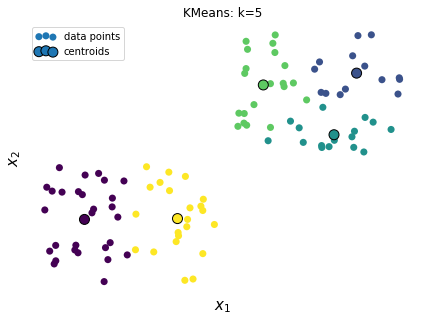

In [15]:
#                                                  CODE:
#                              --------------------------------------------
k = 5
km = KMeans(k, seed=13)
km.fit(points)

#                                                PLOTTING:
#                              --------------------------------------------

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)
 
# For ease, from now on, we will allow matplotlib so select the colors on its own
ax.scatter(points[:, 0], points[:, 1], c=km.predict(points), s=50, lw=0, label='data points')
ax.scatter(km.centroids[:, 0], km.centroids[:, 1], c=range(k), s=100, lw=1, edgecolor='black', label='centroids')    
    
# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: k={}'.format(k))

ax.legend(loc='upper left', scatterpoints=3)

Is this a worse solution to the problem than that with $k=2$? Is there a way to confirm this?

What if we had a more complex problem where we wouldn't know what $k$ to use?

Text(0.5,1,'Data Points')

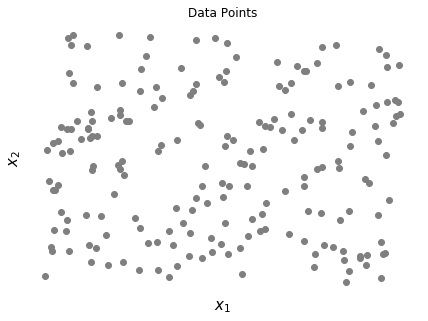

In [16]:
#                                                  CODE:
#                              --------------------------------------------

np.random.seed(77)

# We'll create 4 groups of 50 points with centers in the positions (7,7), (7,17), (17,7) και (17,17)
# The points will be highly dispersed so the groups won't be clearly visible

lowb, highb, var = 2, 12, 10

p1 = np.random.rand(50, 2) * var + lowb
p2 = np.random.rand(50, 2) * var + highb

a = np.array([highb] * 50)
b = np.array([lowb] * 50)
c = np.zeros((50, 2))
c[:, 0], c[:, 1] = a, b
p3 = np.random.rand(50, 2) * var + c
c[:, 1], c[:, 0] = a, b
p4 = np.random.rand(50, 2) * var + c

points = np.concatenate([p1, p2, p3, p4])

#                                                PLOTTING:
#                              --------------------------------------------

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Scatter new points
ax.scatter(points[:, 0], points[:, 1], c='#7f7f7f')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Data Points'.format(k))

Select whichever value of $k$ you feel appropriate.

Select value for k: 5


Text(0.5,1,'k-means clustering for k=5')

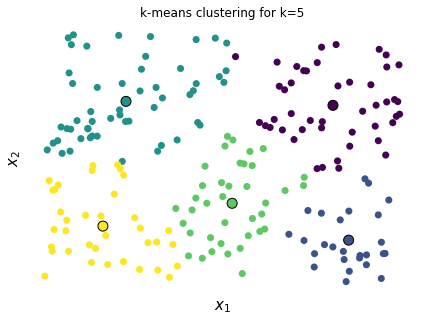

In [17]:
#                                                  CODE:
#                              --------------------------------------------

k = int(input('Select value for k: '))
km = KMeans(k, seed=77)
km.fit(points)

#                                                PLOTTING:
#                              --------------------------------------------


# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Scatter new points
ax.scatter(points[:, 0], points[:, 1], c=km.predict(points), lw=0, s=50)
ax.scatter(km.centroids[:, 0], km.centroids[:, 1], c=range(k), lw=1, edgecolor='black', s=100)

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('k-means clustering for k={}'.format(k))

We'll draw a few more for $k = {2, 3, 4, 5, 6, 7}$.

(1.1059088078967556, 22.996506284740057, 1.1422364615185807, 22.90947757852765)

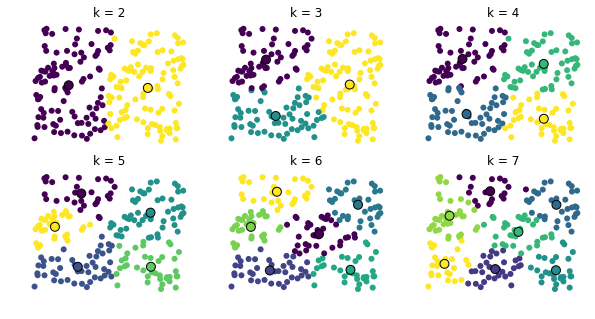

In [18]:
#                                                PLOTTING:
#                              --------------------------------------------

# Create 6 subplots
f, ax = plt.subplots(2, 3, figsize=(10, 5))
seed = 55

# k = 2
km = KMeans(2, seed=seed)
ax[0, 0].scatter(points[:, 0], points[:, 1], c=km.fit_predict(points), lw=0)
ax[0, 0].scatter(km.centroids[:, 0], km.centroids[:, 1], c=range(km.k), lw=1, edgecolor='black', s=80)
ax[0, 0].set_title('k = 2')
ax[0, 0].axis('off')

# k = 3
km = KMeans(3, seed=seed)
ax[0, 1].scatter(points[:, 0], points[:, 1], c=km.fit_predict(points), lw=0)
ax[0, 1].scatter(km.centroids[:, 0], km.centroids[:, 1], c=range(km.k), lw=1, edgecolor='black', s=80)
ax[0, 1].set_title('k = 3')
ax[0, 1].axis('off')

# k = 4
km = KMeans(4, seed=seed)
ax[0, 2].scatter(points[:, 0], points[:, 1], c=km.fit_predict(points), lw=0)
ax[0, 2].scatter(km.centroids[:, 0], km.centroids[:, 1], c=range(km.k), lw=1, edgecolor='black', s=80)
ax[0, 2].set_title('k = 4')
ax[0, 2].axis('off')

# k = 5
km = KMeans(5, seed=seed)
ax[1, 0].scatter(points[:, 0], points[:, 1], c=km.fit_predict(points), lw=0)
ax[1, 0].scatter(km.centroids[:, 0], km.centroids[:, 1], c=range(km.k), lw=1, edgecolor='black', s=80)
ax[1, 0].set_title('k = 5')
ax[1, 0].axis('off')

# k = 6
km = KMeans(6, seed=seed)
ax[1, 1].scatter(points[:, 0], points[:, 1], c=km.fit_predict(points), lw=0)
ax[1, 1].scatter(km.centroids[:, 0], km.centroids[:, 1], c=range(km.k), lw=1, edgecolor='black', s=80)
ax[1, 1].set_title('k = 6')
ax[1, 1].axis('off')

# k = 7
km = KMeans(7, seed=seed)
ax[1, 2].scatter(points[:, 0], points[:, 1], c=km.fit_predict(points), lw=0)
ax[1, 2].scatter(km.centroids[:, 0], km.centroids[:, 1], c=range(km.k), lw=1, edgecolor='black', s=80)
ax[1, 2].set_title('k = 7')
ax[1, 2].axis('off')

So, how should we select the value of $k$ in this task? Is there an objective way to measure whether or not one of the above results is better than the other?

## Clustering Evaluation

In order to be able to select the value of $k$ that yields the best results, we first need a way to **objectively** evaluate the performance of a clustering algorithm.

We can't use any of the metrics we described in previous tutorials (e.g. accuracy, precision, recall), as they compare the algorithm's predictions to the class labels. However, as stated previously, in unsupervised problems there aren't any labels accompanying the data. So how can we measure the performance of a clustering algorithm?

One way involves comparing the relationships in the clustered data. The simplest metric we could think of is to compare the variance of the samples of each cluster.

For the cluster $C$ this can be calculated through the following formula:

$$
I_C = \sum_{i \in C}{(x_i - \bar{x}_C)^2}
$$

where $x_i$ is an example that belongs to cluster $C$ with a centroid $\bar{x}_C$.

The smaller the value of $I_C$, the less the variance in cluster $C$, meaning that the cluster is more "compact". Metrics like this are called **inertia**. To calculate the total inertia, we can just sum the inertia of each cluster.

$$
Ι = \sum_{C = 1}^k{I_C}
$$

Many times, this is be divided with the total variance of the data.

From now on we will be using the [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) estimator from scikit-learn, which provides more features and is better optimized than our simpler implementation.

Text(0.5,1,'k-means for k=5\nInertia=2693.52')

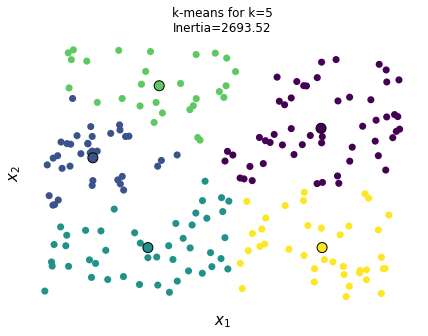

In [19]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.cluster import KMeans

k = 5
km = KMeans(k, random_state=99)
km.fit(points)


#                                                PLOTTING:
#                              --------------------------------------------

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Scatter data points and centroids
ax.scatter(points[:, 0], points[:, 1], c=km.predict(points), lw=0, s=50)
ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c=range(km.n_clusters), lw=1, edgecolor='black', s=100)

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('k-means for k={}\nInertia={:.2f}'.format(k, km.inertia_))

As stated previously, the lower the value of inertia the better. An initial thought would be to try to **minimize** this criterion. Let's run k-means with $k={2, ..., 100}$ to see which value minimizes the inertia.

Text(0.5,1,'Inertia for different values of k')

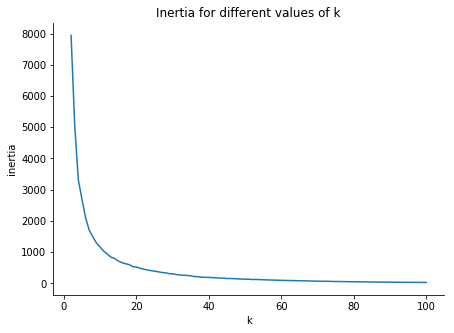

In [20]:
#                                                  CODE:
#                              --------------------------------------------

cluster_scores = []
for k in range(2, 101):
    km = KMeans(k, random_state=77)
    km.fit(points)
    cluster_scores.append(km.inertia_)

#                                                PLOTTING:
#                              --------------------------------------------

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Plot total inertia for all values of k
ax.plot(range(2, 101), cluster_scores)

# Aesthetic parameters
ax.set_xlabel('k')
ax.set_ylabel('inertia')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_title('Inertia for different values of k')

From the figure above, we can observe that as $k$ increases, the system's total inertia decreases. This makes sense because more clusters in the system, will result in each of them having only few examples, close to their centroid. This means that the total  variance of the system will decrease, as the number of clusters ($k$) increases. Finally, when $k=N$ (where $N$ is the total number of examples) inertia will reach 0.

Can inertia help us select the best $k$? Not directly.

We can use an **empirical** criterion called the [elbow][1]. To use this, we simply draw the inertia curve and look for where it forms an "elbow".

[1]: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

Text(0.5,1,'Elbow criterion')

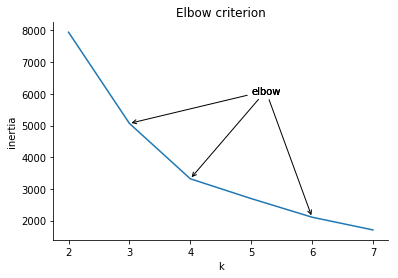

In [21]:
#                                                PLOTTING:
#                              --------------------------------------------

# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Draw first 6 values of k
plt.plot(range(2,8), cluster_scores[:6])
plt.annotate("elbow", xy=(3, cluster_scores[1]), xytext=(5, 6000),arrowprops=dict(arrowstyle="->"))
plt.annotate("elbow", xy=(4, cluster_scores[2]), xytext=(5, 6000),arrowprops=dict(arrowstyle="->"))
plt.annotate("elbow", xy=(6, cluster_scores[4]), xytext=(5, 6000),arrowprops=dict(arrowstyle="->"))

# Aesthetic parameters
ax.set_xlabel('k')
ax.set_ylabel('inertia')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_title('Elbow criterion')

In the figure above we could choose $k=3$, $k=4$ or $k=6$. This method however is **highly subjective** and even if we used an objective method of figuring out the "sharpest" elbow (e.g. looking at the curve's second derivative), it still wouldn't produce any objective results, as the criterion is empirical.

In order to get an **objective** evaluation on our clustering method's performance we need to dive a bit deeper into [clustering evaluation](https://en.wikipedia.org/wiki/Cluster_analysis#Evaluation_and_assessment). There are two main categories here:

- Extrinsic evaluation: Involves running the clustering algorithm in a supervised problem, where class labels are available. They are obviously not included during the training phase but are used for evaluation. However, this type of evaluation can't be applied to any truly unsupervised problems.
- Intrinsic evaluation: Requires analyzing the structure of the clusters, much like inertia we saw previously.

### Intrinsic Clustering Evaluation

These metrics analyze the structure of the clusters and try to produce better scores for solutions with more "compact" clusters. Inertia did this by measuring the variance within each cluster. The problem with inertia, was that it rewarded solutions with more clusters. We are now going to examine two metrics that reward solutions with fewer (more sparse) clusters:

- [Dunn index](https://en.wikipedia.org/wiki/Dunn_index):  
This metric consists of two parts:  
 - The nominator is a measure of the **distance between two clusters**. This could be the distance between their centroids, the distance between their closest points, etc.  
 - The denominator is a measure of the **size of the largest cluster**. This could be the largest distance between a centroid and the most remote point assigned to it, the maximum distance between two points of the same cluster, etc.

$$
DI= \frac{ min \left( δ \left( C_i, C_j \right) \right)}{ max \, Δ_p }
$$

where $C_i, C_j$ are two random centroids, $δ \left( C_i, C_j \right)$ is a measure of their distance and $Δ_p$ in a measure of the size of cluster $p$, where $p \in [0,k]$. 

The larger Dunn index is, the better the solution. The denominator of this index deals with the size of the clusters. Solutions with smaller (or more "**compact**") clusters produce a smaller denominator, which increases the index's value. The nominator becomes larger the farther apart the clusters are, which rewards **sparse solutions** with fewer clusters. 

- [Silhouette coefficient][1]:  
Like Dunn, this metric two can be decomposed into two parts. For cluster $i$:  
 - A measure of cluster **homogeneity** $a(i)$ (e.g. the mean distance of all points assigned to $i$, to its centroid).  
 - A measure of cluster $i$'s **distance to its nearest cluster** $b(i)$ (e.g. the distance of their centroids, the distance of their nearest points etc.)

The silhouette coefficient is defined for each cluster separately:

$$
s \left( i \right) = \frac{b \left( i \right) - a \left( i \right) }{max \left( a \left( i \right) , b \left( i \right) \right)}
$$

A small value of $a(i)$ means cluster $i$ is more "compact", while a large $b(i)$ means that $i$ is far away from its nearest cluster. It is apparent that larger values of the nominator are better. The denominator scales the index to $[-1, 1]$. The best score we can achieve is $s(i) \approx 1$ for $b(i) >> a(i)$.

In order to evaluate our algorithm, we usually average the silhouette coefficients $s(i)$ for all the clusters.

We'll now attempt to use the silhouette coefficient to figure out the best $k$ for our previous problem.

[1]: https://en.wikipedia.org/wiki/Silhouette_(clustering)

Maximum average silhouette score for k = 61


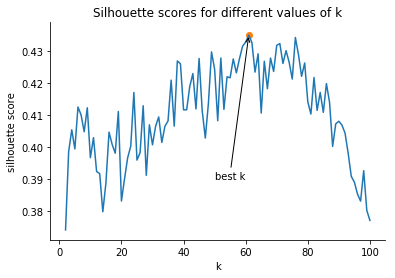

In [22]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 101):
    km = KMeans(k, random_state=77)
    km.fit(points)
    preds = km.predict(points)
    silhouette_scores.append(silhouette_score(points, preds))

#                                                PLOTTING:
#                              --------------------------------------------

# Find out the value of k which produced the best silhouette score
best_k = np.argmax(silhouette_scores) + 2  # +2 because range() begins from k=2 

# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Draw figures
ax.plot(range(2, 101), silhouette_scores)
ax.scatter(best_k, silhouette_scores[best_k-2], color='#ff7f0e') 
ax.annotate("best k", xy=(best_k, silhouette_scores[best_k-2]), xytext=(50, 0.39), arrowprops=dict(arrowstyle="->"))

# Aesthetic parameters
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_title('Silhouette scores for different values of k')

print('Maximum average silhouette score for k =', best_k)

Let's draw the clustering solution for $k=61$.

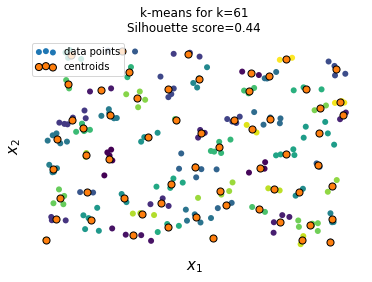

In [23]:
#                                                  CODE:
#                              --------------------------------------------

km = KMeans(best_k, random_state=77)
preds = km.fit_predict(points)

#                                                PLOTTING:
#                              --------------------------------------------

# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Draw assigned points
ax.scatter(points[:,  0], points[:, 1], c=preds, lw=0, label='data points')
ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:,1], c='#ff7f0e', s=50, lw=1, edgecolor='black', label='centroids')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('k-means for k={}\nSilhouette score={:.2f}'.format(best_k, silhouette_scores[best_k-2]))

plt.legend(loc='upper left', scatterpoints=3)

This result, however, still might not be desirable due to the large number of clusters. In most applications it doesn't help us very much to cluster 200 points into 61 clusters. We could take that into account and add another restriction to our problem: only examine solutions with 20 or less clusters.

A good value for k is: k = 6


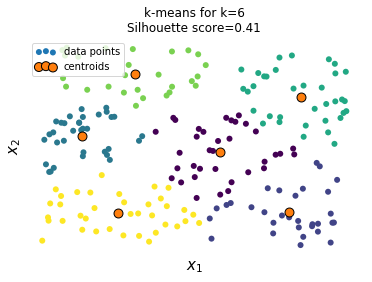

In [24]:
#                                                  CODE:
#                              --------------------------------------------

good_k = np.argmax(silhouette_scores[:10]) + 2
km = KMeans(good_k, random_state=77)
preds = km.fit_predict(points)

#                                                PLOTTING:
#                              --------------------------------------------

# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Draw assigned points
ax.scatter(points[:, 0], points[:, 1], c=preds, lw=0, label='data points')
ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:,1], c='#ff7f0e', s=80, lw=1, edgecolor='black', label='centroids')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('k-means for k={}\nSilhouette score={:.2f}'.format(good_k, silhouette_scores[good_k-2]))

ax.legend(loc='upper left', scatterpoints=3)

print('A good value for k is: k =', good_k)

We can view where this solution's silhouette score ranks compared to the best solution.

Text(0.5,1,'Silhouette scores for different values of k')

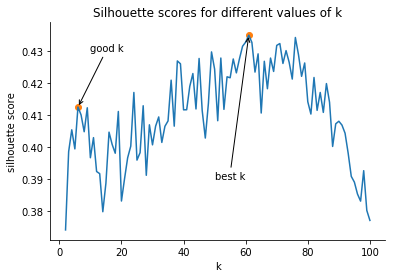

In [25]:
#                                                PLOTTING:
#                              --------------------------------------------

# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Draw figure
ax.plot(range(2, 101), silhouette_scores)
ax.scatter([good_k, best_k], [silhouette_scores[good_k-2], silhouette_scores[best_k-2]], color='#ff7f0e')
ax.annotate("best k", xy=(best_k, silhouette_scores[best_k-2]), xytext=(50, 0.39), arrowprops=dict(arrowstyle="->"))
ax.annotate("good k", xy=(good_k, silhouette_scores[good_k-2]), xytext=(10, 0.43), arrowprops=dict(arrowstyle="->"))

# Aesthetic parameters
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_title('Silhouette scores for different values of k')

Now we normally would want to decide if the drop-off in the silhouette score is acceptable.

We could also generate a list of candidate values of $k$ and select the best one manually.

For k = 19, the average silhouette score is: 0.4112.
For k = 9 , the average silhouette score is: 0.4124.
For k = 6 , the average silhouette score is: 0.4126.


Text(0.5,1,'Silhouette scores for different values of k')

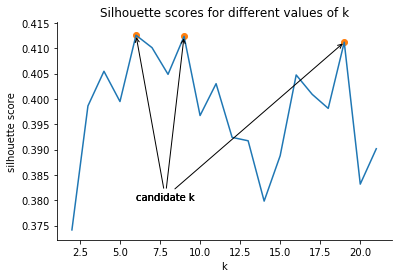

In [26]:
#                                                PLOTTING:
#                              --------------------------------------------

# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Draw figure
topN = 3
ax.plot(range(2, 22), silhouette_scores[:20])
candidate_k = np.argpartition(silhouette_scores[:20], -topN)[-topN:]
ax.scatter([k+2 for k in candidate_k], [silhouette_scores[k] for k in candidate_k], color='#ff7f0e')
for k in candidate_k:
    ax.annotate("candidate k", xy=(k+2, silhouette_scores[k]), xytext=(6, 0.38), arrowprops=dict(arrowstyle="->"))
    print('For k = {:<2}, the average silhouette score is: {:.4f}.'.format(k+2, silhouette_scores[k]))
    
# Aesthetic parameters
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_title('Silhouette scores for different values of k')

It should be noted at this point that cluster evaluation is **highly subjective**. There is no such thing as the "best solution". In the example above one might have preferred the solution that produced the best silhouette score, while another a sparser solution with a worse score.

Scikit-learn offers many [metrics](http://scikit-learn.org/stable/modules/classes.html#clustering-metrics) for cluster evaluation. We need to be careful, however, because some metrics are unfit for use for the selection of $k$.

For example [Calinski-Harabaz](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html):

$$
CH \left( i \right) = \frac{B \left( i \right) / \left( k - 1 \right) }{W \left( i \right) / \left( N - k \right)}
$$

where $N$ is the number of samples, $k$ is the number of clusters, $i$ is a cluster ($i \in \{1, ..., k \}$), $B \left( i \right)$ is an intra-cluster variance metric (e.g. the mean squared distance between the cluster centroids) and $W \left( i \right)$ is an inter-cluster variance metric (e.g. the mean squared distance between points of the same cluster).

Maximum Calinski-Harabaz score for k = 99


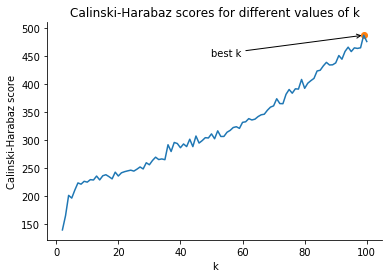

In [27]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.metrics import calinski_harabaz_score

ch_scores = []
for k in range(2, 101):
    km = KMeans(k, random_state=77)
    km.fit(points)
    preds = km.predict(points)
    ch_scores.append(calinski_harabaz_score(points, preds))

#                                                PLOTTING:
#                              --------------------------------------------

# Find best score
ch_k = np.argmax(ch_scores) + 2


# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Draw figures
ax.plot(range(2, 101), ch_scores)
ax.scatter(ch_k, ch_scores[ch_k-2], color='#ff7f0e') 
ax.annotate("best k", xy=(ch_k, ch_scores[ch_k-2]), xytext=(50, 450), arrowprops=dict(arrowstyle="->"))

# Aesthetic parameters
ax.set_xlabel('k')
ax.set_ylabel('Calinski-Harabaz score')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_title('Calinski-Harabaz scores for different values of k')

print('Maximum Calinski-Harabaz score for k =', ch_k)

Note: For visualization purposes, in this tutorial, we've used only data with two dimensions. The same principles apply to data of any dimensionality.

## Bonus material

### Methods for the selection of **k**:

[1](https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/), [2](http://www.sthda.com/english/articles/29-cluster-validation-essentials/96-determining-the-optimal-number-of-clusters-3-must-know-methods/)

### Initialization

Until now, we've initialized the algorithm by creating $k$ centroids and placing them randomly, in the same space as the data. The initialization of k-means is very important for optimal convergence. We'll illustrate this through an example. 

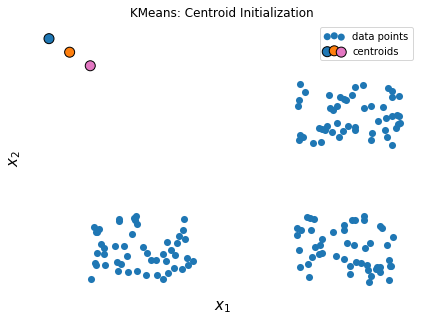

In [28]:
#                                                  CODE:
#                              --------------------------------------------

# We'll make 3 groups of 50 points each with centers in the positions (7,7), (17,7) and (17,17)
np.random.seed(77)

lowb, highb, var = 2, 12, 5

p1 = np.random.rand(50, 2) * var + lowb
p2 = np.random.rand(50, 2) * var + highb

a = np.array([highb] * 50)
b = np.array([lowb] * 50)
c = np.zeros((50, 2))
c[:, 0], c[:, 1] = a, b
p3 = np.random.rand(50, 2) * var + c

points = np.concatenate([p1, p2, p3])

# Place 3 centroids in the positions (0,20), (1,19) and (2,18)
centroids = np.array([[0, 20], [1, 19], [2, 18]])

#                                                PLOTTING:
#                              --------------------------------------------

map_colors = {0: '#1f77b4', 1:'#ff7f0e', 2:'#e377c2'}
color_list = ['#1f77b4', '#ff7f0e', '#e377c2']


# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Draw figures
ax.scatter(points[:, 0], points[:, 1], lw=0, s=50, label='data points')
ax.scatter(centroids[:, 0], centroids[:, 1], c=color_list, s=100, lw=1, edgecolor='black', label='centroids')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: Centroid Initialization')

ax.legend(loc='upper right', scatterpoints=3)

There clearly are 3 groups of points and 3 centroids nearby. Normally, we would expect each centroid to claim one group. Let's run the first iteration to see how the centroids move.

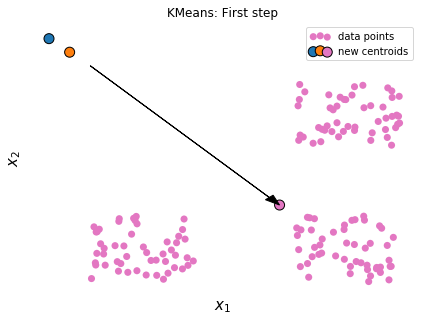

In [29]:
#                                                  CODE:
#                              --------------------------------------------

new_centroids = update_centers(centroids, points) 

#                                                PLOTTING:
#                              --------------------------------------------

colors = [map_colors[i] for i in assign_cluster(new_centroids, points)]

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Draw figures
ax.scatter(points[:, 0], points[:, 1], c=colors, lw=0, s=50, label='data points')
ax.scatter(new_centroids[:, 0], new_centroids[:, 1], c=color_list, s=100, edgecolors='black', label='new centroids')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: First step')

ax.legend(loc='upper right', scatterpoints=3)

ax.arrow(centroids[2, 0], centroids[2, 1], new_centroids[2, 0] - centroids[2, 0], new_centroids[2, 1] - centroids[2, 1], 
         length_includes_head=True, head_width=0.5, color='black')

The first iteration updated one of the 3 centroids. Let's run one more...

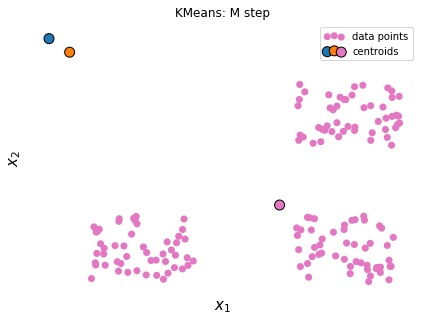

In [30]:
#                                                  CODE:
#                              --------------------------------------------

centroids = new_centroids
new_centroids = update_centers(centroids, points) 

#                                                PLOTTING:
#                              --------------------------------------------

colors = [map_colors[i] for i in assign_cluster(new_centroids, points)]

# Create figure
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111)

# Draw figures
ax.scatter(points[:, 0], points[:, 1], c=colors, lw=0, s=50, label='data points')
ax.scatter(new_centroids[:, 0], new_centroids[:, 1], c=color_list, s=100, edgecolors='black', label='centroids')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: M step')

ax.legend(loc='upper right', scatterpoints=3)

We can run the cell above as many times as we want, the centroids won't move. The reason becomes apparent once we draw the decision boundary.

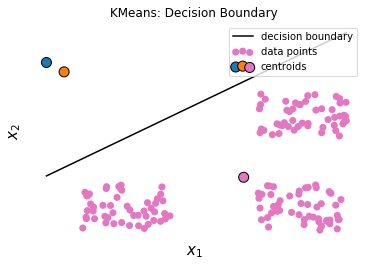

In [31]:
#                                                PLOTTING:
#                              --------------------------------------------

# Generate the decision boudary between the pink and the orange centroids
decision_boundary = generate_perp_bisector(centroids[1:, :])

# Find the range of values along the x axis
x_min = min([points[:, 0].min(), centroids[:, 0].min()])
x_max = max([points[:, 0].max(), centroids[:, 0].max()])
x_range = [x_min, x_max]

# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Draw figures
ax.scatter(points[:, 0], points[:, 1], c=colors, lw=0, s=50, label='data points')
ax.scatter(new_centroids[:, 0], new_centroids[:, 1], c=color_list, s=100, edgecolors='black', label='centroids')
ax.plot(x_range, decision_boundary(x_range), c='black', label='decision boundary')

# Aesthetic parameters
ax.set_xlabel('$x_1$', size=15)
ax.set_ylabel('$x_2$', size=15)

ax.tick_params(axis='both', which='both', bottom=False, left=False,
               top=False, right=False, labelbottom=False, labelleft=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('KMeans: Decision Boundary')

ax.legend(loc='upper right', scatterpoints=3)

Because all the data points have been assigned to one of the three clusters, the remaining two are impossible to update. This issue was caused by the bad initialization of the centroids. The best-known technique for initializing the centroids in k-means is called [K-means++](https://en.wikipedia.org/wiki/K-means%2B%2B).

K-means++ is also the default method for initialization in scikit-learn's k-means estimator. Furthermore, scikit-learn by default runs the algorithm 10 times for different initial conditions and selects the solution that minimizes the total inertia of the system.

### Computational complexity

The time complexity of the k-means algorithm is:

$$
O \left( k \cdot N \cdot d \cdot i \right)
$$

where

- **k** is the number of clusters.
- **N** is the number of examples.
- **d** is the number of dimensions of each example.
- **i** is the number of iterations until convergence.

Because k-means typically converges after a few iterations, k-means is often considered to have "linear" complexity and in practice it is one of the **fastest** clustering algorithms. The issue with k-means it that it can easily fall into **local minima** (like we saw previously due to bad initialization). Using k-means++ initialization can add an additional complexity, but usually helps the algorithm to converge faster. 

### Comparison to other clustering algorithms

K-means is considered a  **centroid-based hard clustering** algorithm.

#### Hard vs soft clustering

Clustering algorithms can be split into two main categories: **hard** and **soft (or fuzzy)** clustering algorithms. The first place each example in a separate group, while the second return a probability for each example to belong in a specific category.

A **soft clustering** solution is depicted below:
![](https://knowm.org/wp-content/uploads/EM-density-data1.png)

An example of such an algorithm is the [Expectation-Maximization (ΕΜ)](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) algorithm.

#### Hierarchical clustering

These algorithms create a whole hierarchy of clusters. This way each example can belong to multiple clusters of different hierarchies.

![](http://www.statisticshowto.com/wp-content/uploads/2016/11/clustergram.png)